# Receptive Field Block Net

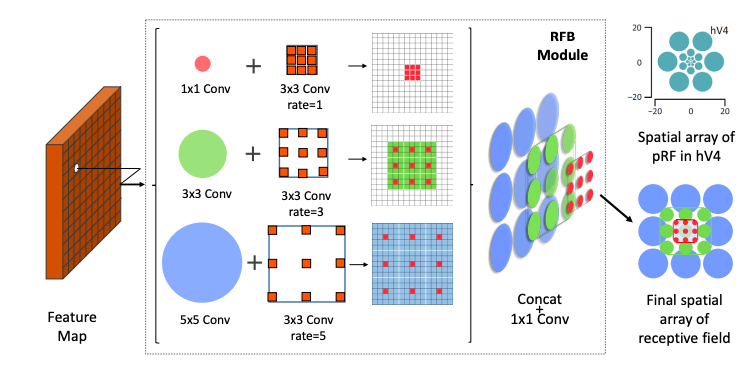

Receptive Field Black module 

In [1]:
import torch.nn as nn
import torch
import torchvision.models as models

In [117]:
def conv_block2(in_channel,out_channel,ceil_mode=False):
    return nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
                         nn.ReLU(inplace=True),
                         nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=ceil_mode))
                         
def conv_block3(in_channel,out_channel,ceil_mode=False):
    return nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=3,padding=1),
                         nn.ReLU(inplace=True),
                         nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1),
                         nn.ReLU(inplace=True),
                         nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=ceil_mode)
                        )

In [118]:
conv_block2(3,64)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

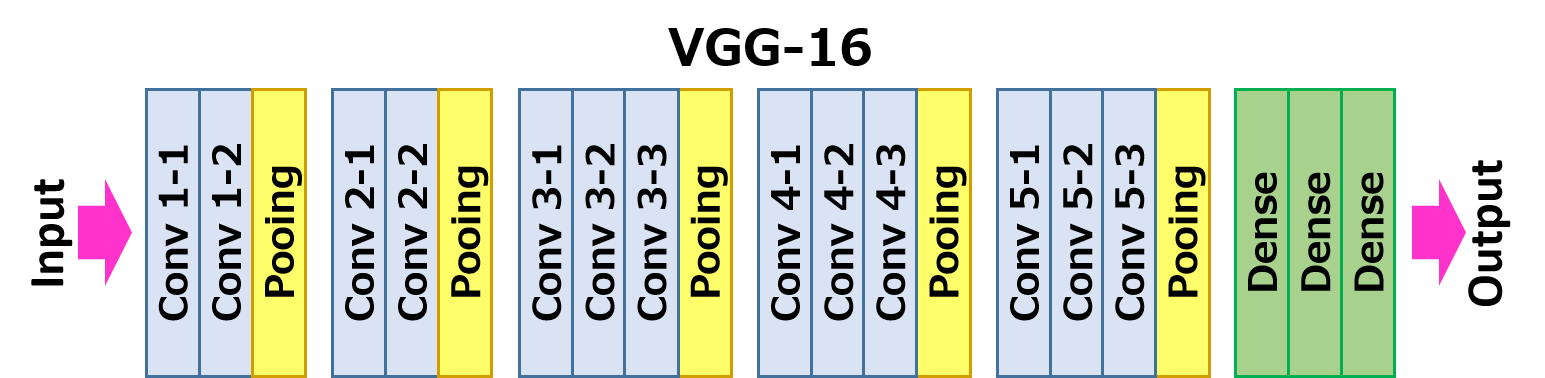

backbone : vgg16
fc layers are converted into conv layers

In [119]:
conv4_3 = nn.Sequential(conv_block2(3,64), #conv1
                        conv_block2(64,128), #conv2
                        conv_block3(128,256,True), #conv3
                        nn.Conv2d(256,512,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(512,512,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(512,512,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True), #conv4_3
                        )

In [120]:
conv4_3_out = conv4_3(torch.randn(1,3,300,300))
conv4_3_out.size()

torch.Size([1, 512, 38, 38])

In [121]:
conv7_fc = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=False), #pooling4
                         nn.Conv2d(512,512,kernel_size=3, padding=1), #conv5_1
                         nn.ReLU(inplace=True), 
                         nn.Conv2d(512,512,kernel_size=3, padding=1), #conv5_2
                         nn.ReLU(inplace=True),
                         nn.Conv2d(512,512,kernel_size=3, padding=1), #conv5_3
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=3, stride=1, padding=1), #pooling5
                         nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
                         nn.ReLU(inplace=True),
                         nn.Conv2d(1024, 1024, kernel_size=1),
                         nn.ReLU(inplace=True))

In [122]:
conv7_fc(conv4_3_out).size()

torch.Size([1, 1024, 19, 19])

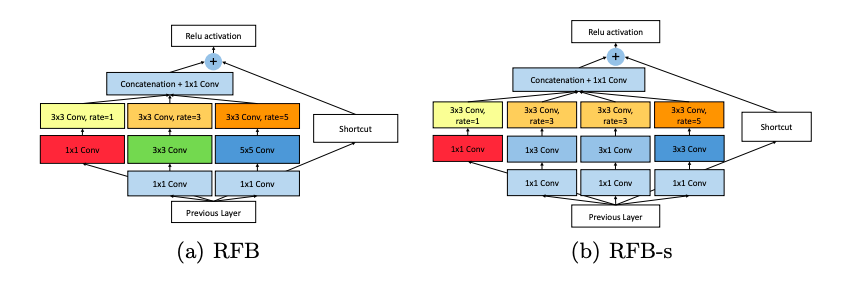

Although conv(conv(x)) (consecutive conv layers) can extract more features, at the view of stability of full network, I decide to add ReLU and BatchNormalization after Conv layer

As you can see there are 2 1X1 conv layer after previous output. However, it doesn't matter we apply 1X1 Conv to all branches. (It might cost a little bit more, but just little bit). 

5X5 Conv : At the paper, 5X5 Conv layer is replaced by two 3X3 Conv layers to reduce parameters

In [2]:
from RFBNet import *

class RFBNet(nn.Module):
    """RFB Net for object detection
    The network is based on the SSD architecture.
    Each multibox layer branches into
        1) conv2d for class conf scores
        2) conv2d for localization predictions
        3) associated priorbox layer to produce default bounding
           boxes specific to the layer's feature map size.
    See: https://arxiv.org/pdf/1711.07767.pdf for more details on RFB Net.
    Args:
        phase: (string) Can be "test" or "train"
        base: VGG16 layers for input, size of either 300 or 512
        extras: extra layers that feed to multibox loc and conf layers
        head: "multibox head" consists of loc and conf conv layers
    """

    def __init__(self, phase, size, base, extras, head, num_classes):
        super(RFBNet, self).__init__()
        self.phase = phase
        self.num_classes = num_classes
        self.size = size

        if size == 300:
            self.indicator = 3
        elif size == 512:
            self.indicator = 5
        # vgg network
        self.base = nn.ModuleList(base)
        # conv_4
        self.Norm = BasicRFB_a(512,512,stride = 1,scale=1.0)
        self.extras = nn.ModuleList(extras)

        self.loc = nn.ModuleList(head[0])
        self.conf = nn.ModuleList(head[1])
        if self.phase == 'test':
            self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """Applies network layers and ops on input image(s) x.
        Args:
            x: input image or batch of images. Shape: [batch,3*batch,300,300].
        Return:
            Depending on phase:
            test:
                list of concat outputs from:
                    1: softmax layers, Shape: [batch*num_priors,num_classes]
                    2: localization layers, Shape: [batch,num_priors*4]
                    3: priorbox layers, Shape: [2,num_priors*4]
            train:
                list of concat outputs from:
                    1: confidence layers, Shape: [batch*num_priors,num_classes]
                    2: localization layers, Shape: [batch,num_priors*4]
                    3: priorbox layers, Shape: [2,num_priors*4]
        """
        sources = list()
        loc = list()
        conf = list()

        # apply vgg up to conv4_3 relu
        for k in range(23):
            x = self.base[k](x)

        s = self.Norm(x)
        sources.append(s)

        # apply vgg up to fc7
        for k in range(23, len(self.base)):
            x = self.base[k](x)

        # apply extra layers and cache source layer outputs
        for k, v in enumerate(self.extras):
            x = v(x)
            if k < self.indicator or k%2 ==0:
                sources.append(x)

        # apply multibox head to source layers
        for (x, l, c) in zip(sources, self.loc, self.conf):
            #print("loc : ",l(x).size()," -> append -> ",l(x).permute(0, 2, 3, 1).contiguous().size())
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            #print("conf : ",c(x).size()," -> append -> ",c(x).permute(0, 2, 3, 1).contiguous().size())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        #print([o.size() for o in loc])


        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        if self.phase == "test":
            output = (
                loc.view(loc.size(0), -1, 4),                   # loc preds
                self.softmax(conf.view(-1, self.num_classes)),  # conf preds
            )
        else:
            output = (
                loc.view(loc.size(0), -1, 4),
                conf.view(conf.size(0), -1, self.num_classes),
            )
        return output

    def load_weights(self, base_file):
        other, ext = os.path.splitext(base_file)
        if ext == '.pkl' or '.pth':
            print('Loading weights into state dict...')
            self.load_state_dict(torch.load(base_file))
            print('Finished!')
        else:
            print('Sorry only .pth and .pkl files supported.')


# This function is derived from torchvision VGG make_layers()
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
def vgg(cfg, i, batch_norm=False):
    layers = []
    in_channels = i
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return layers

base = {
    '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
    '512': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
}


def add_extras(size, cfg, i, batch_norm=False):
    # Extra layers added to VGG for feature scaling
    layers = []
    in_channels = i
    flag = False
    for k, v in enumerate(cfg):
        if in_channels != 'S':
            if v == 'S':
                if in_channels == 256 and size == 512:
                    layers += [BasicRFB(in_channels, cfg[k+1], stride=2, scale = 1.0, visual=1)]
                else:
                    layers += [BasicRFB(in_channels, cfg[k+1], stride=2, scale = 1.0, visual=2)]
            else:
                layers += [BasicRFB(in_channels, v, scale = 1.0, visual=2)]
        in_channels = v
    if size == 512:
        layers += [BasicConv(256,128,kernel_size=1,stride=1)]
        layers += [BasicConv(128,256,kernel_size=4,stride=1,padding=1)]
    elif size ==300:
        layers += [BasicConv(256,128,kernel_size=1,stride=1)]
        layers += [BasicConv(128,256,kernel_size=3,stride=1)]
        layers += [BasicConv(256,128,kernel_size=1,stride=1)]
        layers += [BasicConv(128,256,kernel_size=3,stride=1)]
    else:
        print("Error: Sorry only RFBNet300 and RFBNet512 are supported!")
        return
    return layers

extras = {
    '300': [1024, 'S', 512, 'S', 256],
    '512': [1024, 'S', 512, 'S', 256, 'S', 256,'S',256],
}


def multibox(size, vgg, extra_layers, cfg, num_classes):
    loc_layers = []
    conf_layers = []
    vgg_source = [-2]
    for k, v in enumerate(vgg_source):
        if k == 0:
            loc_layers += [nn.Conv2d(512,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
            conf_layers +=[nn.Conv2d(512,
                                 cfg[k] * num_classes, kernel_size=3, padding=1)]
        else:
            loc_layers += [nn.Conv2d(vgg[v].out_channels,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
            conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        cfg[k] * num_classes, kernel_size=3, padding=1)]
    i = 1
    indicator = 0
    if size == 300:
        indicator = 3
    elif size == 512:
        indicator = 5
    else:
        print("Error: Sorry only RFBNet300 and RFBNet512 are supported!")
        return

    for k, v in enumerate(extra_layers):
        if k < indicator or k%2== 0:
            loc_layers += [nn.Conv2d(v.out_channels, cfg[i]
                                 * 4, kernel_size=3, padding=1)]
            conf_layers += [nn.Conv2d(v.out_channels, cfg[i]
                                  * num_classes, kernel_size=3, padding=1)]
            i +=1
    return vgg, extra_layers, (loc_layers, conf_layers)

mbox = {
    '300': [6, 6, 6, 6, 4, 4],  # number of boxes per feature map location
    '512': [6, 6, 6, 6, 6, 4, 4],
}


def build_net(phase, size=512, num_classes=2):
    if phase != "test" and phase != "train":
        print("Error: Phase not recognized")
        return
    if size != 300 and size != 512:
        print("Error: Sorry only RFBNet300 and RFBNet512 are supported!")
        return

    return RFBNet(phase, size, *multibox(size, vgg(base[str(size)], 3),
                                add_extras(size, extras[str(size)], 1024),
                                mbox[str(size)], num_classes), num_classes)

In [3]:
net = build_net("train",512,1)

In [4]:
result = net(torch.randn(4,3,512,512))

In [5]:
result[0].shape, result[1].shape

(torch.Size([4, 32756, 4]), torch.Size([4, 32756, 1]))

#### Default anchor boxes


#### Focal loss for class prediction

In [6]:
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, output):
        logpt = output.log()
        return (-1*self.alpha*((1-logpt)**self.gamma)*logpt).mean()

In [233]:
focal = FocalLoss()
output_from_net = torch.Tensor([[0.99],
                                [0.99],
                                [0.99]])

output_from_net2 = torch.Tensor([[0.19],
                                [0.29],
                                [0.09]])
focal(output_from_net), focal(output_from_net2)

(tensor(-2.4750e-05), tensor(-0.0288))

#### loss for bbox

In [16]:
pred_bbox = torch.Tensor([[34,23,45,65],
                          [56,89,10,34]])
ground_truth_bbox = torch.Tensor([[34,26,47,85],
                                  [66,79,50,44]])
smooth_l1 = nn.SmoothL1Loss()
smooth_l1(pred_bbox,ground_truth_bbox)

tensor(11.4375)

### Final Loss

In [17]:
num_classes = 1
out_bbox = result[0].view(-1,4)
out_class = result[1].view(-1,num_classes)

In [18]:
print(out_bbox.size(), out_class.size())

torch.Size([262048, 4]) torch.Size([262048, 2])


In [19]:
bbox_truth = torch.randn(262048,4)*100
class_truth = (torch.randn(262048,1) > 0).long()

In [20]:
focal = FocalLoss()
smooth_l1 = nn.SmoothL1Loss()

loss_cls = focal(out_class,class_truth)
loss_loc = smooth_l1(out_bbox,bbox_truth)

loss = loss_cls + loss_loc

print(loss)

tensor(79.7212, grad_fn=<AddBackward0>)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


### Load Dataset

In [7]:
from data.voc_scut import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [8]:
dataset = VOCDetection("/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD")

dateset init


In [23]:
ex = dataset.pull_item(2)

/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_00282.jpg <Element 'annotation' at 0x12ceaeea8>


In [8]:
im = ex[0].shape

torch.Size([512, 512, 3])

In [27]:
ex[0].permute(2,1,0).view(-1,3,512,512)

torch.Size([1, 3, 512, 512])

In [9]:
def batch_out(pull_idx,batch_size=4):
    batch = []
    annot_ = []
    for i in range(batch_size):
        data = dataset.pull_item(pull_idx)
        img,annot = data[0].permute(2,1,0),data[1]
        batch.append(np.array(img))
        annot_.append(np.array(annot).astype(float))
    batch = np.array(batch)
    batch = torch.Tensor(batch)
    annot_ = np.array(annot_)
    return batch,annot_

In [10]:
img_batch, annot_batch  = batch_out(123)
print("Image batch size : ",img_batch.size(),"\nannot batch size : ",len(annot_batch))

/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01135.jpg <Element 'annotation' at 0x105f67a48>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01135.jpg <Element 'annotation' at 0x105f67a48>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01135.jpg <Element 'annotation' at 0x105f67a48>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01135.jpg <Element 'annotation' at 0x105f67a48>
Image batch size :  torch.Size([4, 3, 512, 512]) 
annot batch size :  4


### Step by Step train mode model flow

In [213]:
out = net(img_batch)
label = annot_batch

loc :  torch.Size([4, 24, 64, 64])  -> append ->  torch.Size([4, 64, 64, 24])
conf :  torch.Size([4, 6, 64, 64])  -> append ->  torch.Size([4, 64, 64, 6])
loc :  torch.Size([4, 24, 32, 32])  -> append ->  torch.Size([4, 32, 32, 24])
conf :  torch.Size([4, 6, 32, 32])  -> append ->  torch.Size([4, 32, 32, 6])
loc :  torch.Size([4, 24, 16, 16])  -> append ->  torch.Size([4, 16, 16, 24])
conf :  torch.Size([4, 6, 16, 16])  -> append ->  torch.Size([4, 16, 16, 6])
loc :  torch.Size([4, 24, 8, 8])  -> append ->  torch.Size([4, 8, 8, 24])
conf :  torch.Size([4, 6, 8, 8])  -> append ->  torch.Size([4, 8, 8, 6])
loc :  torch.Size([4, 24, 4, 4])  -> append ->  torch.Size([4, 4, 4, 24])
conf :  torch.Size([4, 6, 4, 4])  -> append ->  torch.Size([4, 4, 4, 6])
loc :  torch.Size([4, 16, 2, 2])  -> append ->  torch.Size([4, 2, 2, 16])
conf :  torch.Size([4, 4, 2, 2])  -> append ->  torch.Size([4, 2, 2, 4])
loc :  torch.Size([4, 16, 1, 1])  -> append ->  torch.Size([4, 1, 1, 16])
conf :  torch.Size([

In [214]:
out[0].shape, out[1].shape

(torch.Size([4, 32756, 4]), torch.Size([4, 32756, 1]))

In [11]:
def iou(bbox1, bbox2):
    #bbox1 : pred
    #bbox2 : GT
    if(not(bbox1[0] < bbox1[2]) and (bbox1[1] < bbox1[3])):
        return 0
    if(((bbox1[0] < bbox2[0]) and (bbox1[2] < bbox2[0])) or ((bbox2[0] < bbox1[0]) and (bbox2[2] < bbox1[0]))):
        # not overlap
        return 0
    if(((bbox1[1] < bbox2[1]) and (bbox1[3] < bbox2[1])) or ((bbox2[1] < bbox1[1]) and (bbox2[3] < bbox1[1]))):
        return 0
    x1, y1 = max(bbox1[0],bbox2[0]), max(bbox1[1],bbox2[1])
    x2, y2 = min(bbox1[2],bbox2[2]), min(bbox1[3],bbox2[3])

    return ((x2-x1)*(y2-y1))/((bbox1[2]-bbox1[0])*(bbox1[3]-bbox1[1]) + (bbox2[2]-bbox2[0])*(bbox2[3]-bbox2[1]))

In [12]:
from tqdm import tqdm
def matching(out, label, threshold = 0.5):
    #out   shape : ([B,C,4],[B,C,Classes])
    #label shape : (B, Groung Truth BBoxes, 4)
    # note : not efficient
    batch = out[0].shape[0]
    smooth_l1 = nn.SmoothL1Loss()
    pos = torch.Tensor([]).view(-1,4)#pred bbox which is 
    pos_GT = torch.Tensor([]).view(-1,4)
    
    for i in tqdm(range(batch)):
        out_bbox, label_ = out[0][i],label[i]
        positive = []
        for i in out_bbox:
            argmax_,ratio = -1,-1
            for l in range(len(label_)):
                over = iou(i, label_[l][:4])
                if(over > threshold):
                    if(ratio < over):
                        ratio = over
                        argmax_ = l
            if(argmax_ >= 0):
                pos = torch.cat((pos, i.view(-1,4)),0)
                pos_GT = torch.cat((pos_GT, torch.Tensor(label_[argmax_][:4]).view(-1,4)),0)
            
    return pos,pos_GT

In [185]:
pos,pos_GT = matching(out,label)

100%|██████████| 4/4 [00:45<00:00, 11.18s/it]


In [188]:
pos.size(), pos_GT.size()

(torch.Size([1262, 4]), torch.Size([1262, 4]))

In [215]:
smooth_l1 = nn.SmoothL1Loss()
loss_loc = smooth_l1(pos,pos_GT)
print(loss_loc)

tensor(0.0515, grad_fn=<SmoothL1LossBackward>)


In [238]:
focal = FocalLoss()

sigmoid = nn.Sigmoid()
loss_cls = focal(sigmoid(out[1]))
print(loss_cls)

tensor(0.4936, grad_fn=<MeanBackward0>)


## train model

In [13]:
epoch = 20
smooth_l1 = nn.SmoothL1Loss()
focal = FocalLoss()
sigmoid = nn.Sigmoid()
optimizer = torch.optim.Adam(net.parameters())


for ep in range(epoch):
    loss = 0
    loss_loc = 0
    loss_cls = 0
    for i in range(1):
        img_batch, label  = batch_out(i)
        out = net(img_batch)
        pos,pos_GT = matching(out,label)
        loss_loc += smooth_l1(pos,pos_GT)
        loss_cls += focal(sigmoid(out[1]))
        loss = loss_loc+loss_cls
        print(loss, loss_loc,loss_cls)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("epoch ",ep," ",loss)

/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb354ae8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb1f45e8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb2ca188>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb354c78>


100%|██████████| 4/4 [00:36<00:00,  9.66s/it]


tensor(0.5562, grad_fn=<AddBackward0>) tensor(0.0416, grad_fn=<AddBackward0>) tensor(0.5147, grad_fn=<AddBackward0>)
epoch  0   tensor(0.5562, grad_fn=<AddBackward0>)
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb1f47c8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb364f98>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb2ca228>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb2ca228>


100%|██████████| 4/4 [01:20<00:00, 19.28s/it]


tensor(0.1976, grad_fn=<AddBackward0>) tensor(0.0152, grad_fn=<AddBackward0>) tensor(0.1824, grad_fn=<AddBackward0>)
epoch  1   tensor(0.1976, grad_fn=<AddBackward0>)
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb2ca4a8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb354778>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb377db8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb2ca278>


100%|██████████| 4/4 [02:00<00:00, 26.23s/it]


tensor(nan, grad_fn=<AddBackward0>) tensor(nan) tensor(0.0401, grad_fn=<AddBackward0>)
epoch  2   tensor(nan, grad_fn=<AddBackward0>)
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb354ae8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb364048>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb1f4d68>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb364458>


100%|██████████| 4/4 [00:58<00:00, 11.86s/it]


tensor(0.0406, grad_fn=<AddBackward0>) tensor(0.0298, grad_fn=<AddBackward0>) tensor(0.0108, grad_fn=<AddBackward0>)
epoch  3   tensor(0.0406, grad_fn=<AddBackward0>)
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb1f4ae8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb364ea8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb1f45e8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb1f4f98>


100%|██████████| 4/4 [01:45<00:00, 24.70s/it]


tensor(0.1388, grad_fn=<AddBackward0>) tensor(0.1342, grad_fn=<AddBackward0>) tensor(0.0046, grad_fn=<AddBackward0>)
epoch  4   tensor(0.1388, grad_fn=<AddBackward0>)
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb1f4a48>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb354548>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb377c28>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb2ca188>


100%|██████████| 4/4 [01:24<00:00, 24.33s/it]


tensor(nan, grad_fn=<AddBackward0>) tensor(nan) tensor(0.0023, grad_fn=<AddBackward0>)
epoch  5   tensor(nan, grad_fn=<AddBackward0>)
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb3777c8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb1f4818>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb2ca4a8>
/Users/seungyoun/Desktop/mAyI/RFBNet/data/SCUT_HEAD/SCUT_HEAD_Part_A/JPEGImages/PartA_01252.jpg <Element 'annotation' at 0x1bb2ca4a8>


 50%|█████     | 2/4 [01:10<01:27, 43.89s/it]

KeyboardInterrupt: 

In [260]:
sigmoid(torch.Tensor([10]))


tensor([1.0000])